# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
import tensorflow
tensorflow.__version__

'2.4.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load the "images.npy" file 
- This file contains images with details of bounding boxes

In [5]:
import numpy as np
data = np.load('/content/drive/MyDrive/images.npy', allow_pickle= True)

In [6]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  
- Hint: print data[10][1] 

In [7]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   
- Initialize image height, image width with value: 224 

In [8]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [9]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing 
- 400 images in training
- 9 images in testing data

Training data

In [10]:
X_train = X[0:400] # Taking 400 number of images for training
y_train = masks[0:400] # Taking 400 number of masks for training

In [11]:
X_train.shape, y_train.shape

((400, 224, 224, 3), (400, 224, 224))

Testing data

In [12]:
X_test = X[400:] # Taking 9 number of images for training
y_test = masks[400:] # Taking 9 number of masks for training

In [13]:
X_test.shape, y_test.shape

((9, 224, 224, 3), (9, 224, 224))

### Print a sample training image, image array and its mask 

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


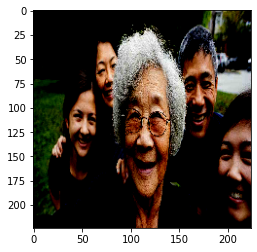

In [14]:
import matplotlib.pyplot as plt
plt.imshow(X_train[309])

Print the mask

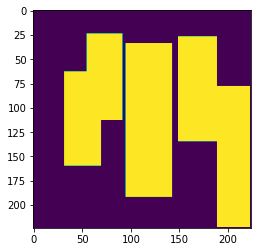

In [15]:
plt.imshow(y_train[309])

## Create the model 
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [16]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)
    

### Call the create_model function 
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [17]:
model = create_model(trainable = True)

17227776/17225924 [==============================] - 0s 0us/step


### Print model summary 

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function 
- Create a function to calculate dice coefficient


In [19]:
import tensorflow
def dice_coefficient (y_true, y_pred):
  numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
  denominator = tensorflow.reduce_sum(y_true + y_pred)

  return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function 

In [20]:
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model 
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [21]:
from tensorflow.keras.optimizers import Adam


optimizer = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = optimizer, metrics = [dice_coefficient])

### Define callbacks
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:0.2f}.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = True)

stop = EarlyStopping(monitor = "loss", patience = 5)

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience =5, min_lr = 1e-6, verbose=1 )

### Fit the model 
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 5
  - callbacks: use the callbacks defined above

In [23]:
model.fit(X_train, y_train, epochs = 12, batch_size = 5, verbose=1, callbacks = [checkpoint, reduce_lr, stop])

Epoch 1/12
80/80 [==============================] - 28s 223ms/step - loss: 1.7510 - dice_coefficient: 0.3614
Epoch 2/12
80/80 [==============================] - 18s 227ms/step - loss: 0.8659 - dice_coefficient: 0.5533
Epoch 3/12
80/80 [==============================] - 19s 232ms/step - loss: 0.6809 - dice_coefficient: 0.6251
Epoch 4/12
80/80 [==============================] - 19s 235ms/step - loss: 0.5921 - dice_coefficient: 0.6716
Epoch 5/12
80/80 [==============================] - 19s 235ms/step - loss: 0.5273 - dice_coefficient: 0.6975
Epoch 6/12
80/80 [==============================] - 19s 232ms/step - loss: 0.4884 - dice_coefficient: 0.7151
Epoch 7/12
80/80 [==============================] - 19s 232ms/step - loss: 0.4800 - dice_coefficient: 0.7324
Epoch 8/12
80/80 [==============================] - 19s 233ms/step - loss: 0.4571 - dice_coefficient: 0.7348
Epoch 9/12
80/80 [==============================] - 19s 233ms/step - loss: 0.4121 - dice_coefficient: 0.7572
Epoch 10/12
80/80 [

### Get the predicted mask for a test image  

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


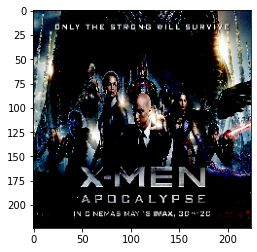

In [24]:
plt.imshow(X_test[8])

Show original mask for test image

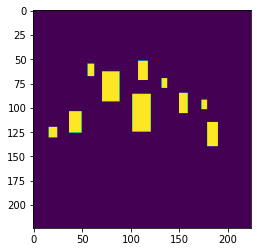

In [25]:
plt.imshow(y_test[8])

Predict the mask on the test image

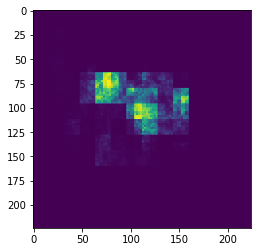

In [26]:
preds = model.predict(X_test)
plt.imshow(preds[8])

### Impose the mask on the test image 
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


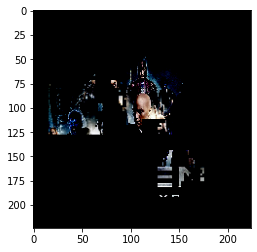

In [27]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([X_test[0]]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image1 = X_test[8]
image1[:,:,0] = pred_mask*image1[:,:,0]
image1[:,:,1] = pred_mask*image1[:,:,1]
image1[:,:,2] = pred_mask*image1[:,:,2]

out_image = image1

plt.imshow(image1)

### Get the predicted mask for a test image  

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


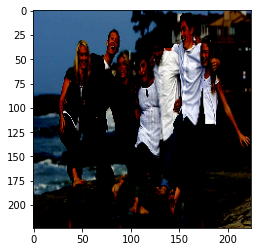

In [28]:
plt.imshow(X_test[2])

Show original mask for test image

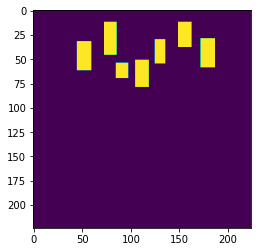

In [29]:
plt.imshow(y_test[2])

Predict the mask on the test image

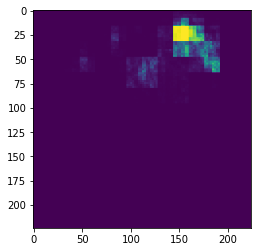

In [30]:
preds = model.predict(X_test)
plt.imshow(preds[2])

### Impose the mask on the test image 

- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


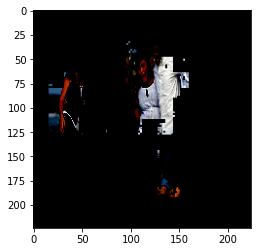

In [31]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([X_test[0]]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image1 = X_test[2]
image1[:,:,0] = pred_mask*image1[:,:,0]
image1[:,:,1] = pred_mask*image1[:,:,1]
image1[:,:,2] = pred_mask*image1[:,:,2]

out_image = image1

plt.imshow(image1)

>>>>>>> **The End**